# Muse EEG

Muse 2 is a headset that measures EEG signals from 4 locations on the surface of the skull. These signals are `TP9`, `TP10`, `AF7`, and `AF8`.

This naming system is called the 10/10 system. It is a global standard for locations where EEG electrodes are placed on the head for reading EEG data, as show in the image below.

![EEG 10/10 system image](../data/EEG-10-10.png)

As we can see from the image, two of the sensors (`TP9`, `TP10`) are located on the frontal lobe, while the other two (`AF7`, `AF8`) is located on the temporal lobe. Given this, we would expect sensors with the same prefix to have similar outputs.

The output from the sensors comes as point-in-time samples of the current reading. We want to process this input and train ML models to associate brain waves with specific *behaviors, events, and emotions*. At the end of this project, we will be able to predict the behavior or emotion of a person in real time using their brainwaves.

First, we can define some data processing functions to help us understand the raw EEG samples.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(67936,) {'C5': 23967.09677419355, 'A4': 22900.58064516129}


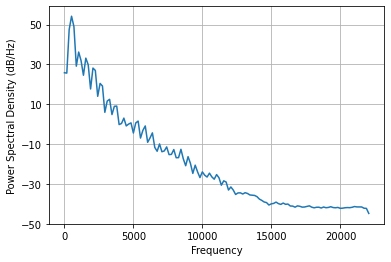

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import src lib with reloads
import sys
sys.path.append("../src")
from config import DEFAULT_SAMPLE_RATE, band_colors, muse2_sensors, eeg_bands
from eeg_preprocessing import preprocess_eeg, preprocess_eeg_channel
from power_spectrum import test_get_band_magnitudes, get_band_magnitudes, band_magnitude_samples
from viz import plot_band_magnitude
%load_ext autoreload
%autoreload 2

%matplotlib inline
test_get_band_magnitudes()

In [9]:
muse_session_lsd_postpeak = pd.read_csv("../data/muse2-recordings/jared/recording_2021-06-10-08.30.37.csv")
muse_session_lsd_postpeak = preprocess_eeg(muse_session_lsd_postpeak)

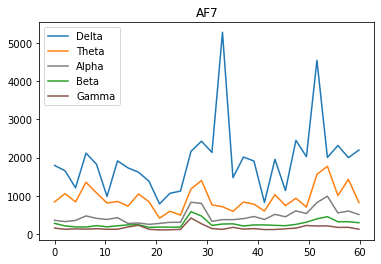

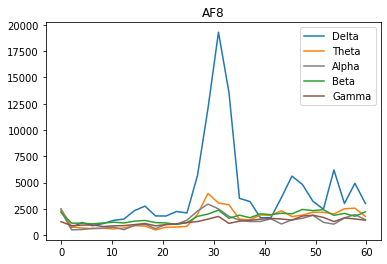

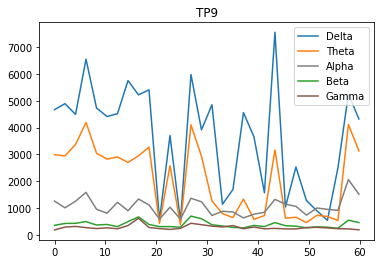

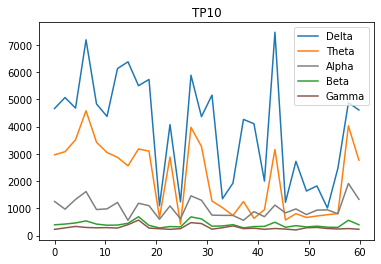

In [12]:
muse_session_lsd_postpeak_duration = muse_session_lsd_postpeak["timestamps"].iloc[-1] - muse_session_lsd_postpeak["timestamps"].iloc[0]
plt.title("AF7")
plot_band_magnitude(preprocess_eeg_channel(muse_session_lsd_postpeak["AF7"]), start_time=0, end_time=muse_session_lsd_postpeak_duration)
plt.title("AF8")
plot_band_magnitude(preprocess_eeg_channel(muse_session_lsd_postpeak["AF8"]), start_time=0, end_time=muse_session_lsd_postpeak_duration)
plt.title("TP9")
plot_band_magnitude(preprocess_eeg_channel(muse_session_lsd_postpeak["TP9"]), start_time=0, end_time=muse_session_lsd_postpeak_duration)
plt.title("TP10")
plot_band_magnitude(preprocess_eeg_channel(muse_session_lsd_postpeak["TP10"]), start_time=0, end_time=muse_session_lsd_postpeak_duration)

As expected, the sensors on opposite sides of the head product similar signals - there is a high degree of covariance in the band magnitudes of both `TP9` and `TP10`, and `AF7` and `AF8`.

# PyTorch EEG Band Image Model

We will use a variation of the techniques outlined in the [Learning Representations from EEG with Deep Recurrent-Convolutional Neural Networks](https://arxiv.org/pdf/1511.06448.pdf) by Bashivan, et al., to convert raw EEG signals into an image containing frequency data per pixel. This spatial representation of signals is perfect for neural networks, specifically networks designed for image processing (RNN, CNN, GRU).

## Conversion of signals to images

To start with, we need to first approximate the location of each sensor on a 2D grid.

![muse 2](../data/muse2-headset.jpg)

The sensors are about equally distributed on the front 45 degrees of the head, so we will approximate the sensor locations using hard-coded x,y indices.

<IPython.core.display.Javascript object>


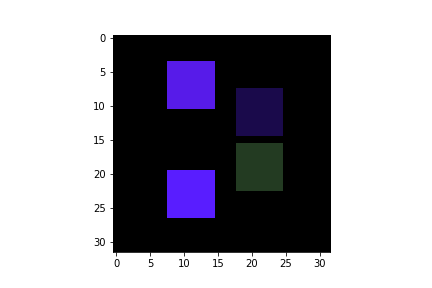

In [17]:
import os
import math
import time
import skimage.io as io

eeg_image_size = 32, 32

sensors_xy = {
    "TP9": (.25, 0.4),
    "TP10": (.75, 0.4),
    "AF7": (.375, 0.7),
    "AF8": (.625, 0.7)
}

def band_samples(eeg_data, frame_size=None, sample_rate=DEFAULT_SAMPLE_RATE):
    """
    Create a DataFrame containing all band magnitudes for all sensors
    Returns: DataFrame, shape=(sensor, band, seq_len).
    """
    # Default to 2s per frame
    if frame_size == None:
        frame_size = int(sample_rate * 2)
    # Calculate frame count
    max_frame = len(eeg_data)
    frame_count = int(np.ceil(max_frame / frame_size))
    
    # Create DataFrame
    index_tuples = [list(sensors_xy.keys()), list(eeg_bands.keys())]
    index = pd.MultiIndex.from_product(index_tuples, names=["sensor", "band"])
    df = pd.DataFrame(np.zeros((len(index), frame_count)), index=index)
    
    # Write data
    for sensor_key in sensors_xy.keys():
        raw_eeg = eeg_data[sensor_key]
        raw_eeg = preprocess_eeg_channel(raw_eeg)
        band_samples = band_magnitude_samples(raw_eeg, frame_size, sample_rate)
        for band_key in band_samples.keys():
            df.loc[sensor_key, band_key] = band_samples[band_key]
            
    # Return DataFrame
    return df

def generate_eeg_images(band_samples, size=eeg_image_size):
    """
    Param band_samples: DataFrame, shape=(sensor, band, seq_len).
    Returns ndarray, shape=(seq_len, size[0], size[1], 4)
    """
    imgs = np.zeros((len(band_samples), size[0], size[1], 4))
    sensor_radius = 0.1
    
    for image_i in range(0, len(band_samples)):
        for sensor_key in sensors_xy.keys():
            x, y = sensors_xy[sensor_key]
            x = int(np.floor(x * size[0]))
            y = int(np.floor(y * size[1]))
            x_range = int(max(0, x-sensor_radius*size[0])), int(min(size[0], x+sensor_radius*size[0]))
            y_range = int(max(0, y-sensor_radius*size[1])), int(min(size[1], y+sensor_radius*size[1]))
            imgs[image_i, x_range[0]:x_range[1], y_range[0]:y_range[1], 0] = band_samples.loc[sensor_key, "Alpha"][image_i]
            imgs[image_i, x_range[0]:x_range[1], y_range[0]:y_range[1], 1] = band_samples.loc[sensor_key, "Beta"][image_i]
            imgs[image_i, x_range[0]:x_range[1], y_range[0]:y_range[1], 2] = band_samples.loc[sensor_key, "Theta"][image_i]
            #imgs[x, y, 3, image_i] = 1.
    
    # Naive scaling
    imgs = imgs / imgs.max()
    # Alpha = 1 for viewing. TODO store additional band?
    imgs[:, :, :, 3] = 1
    
    return imgs

# Create images
bands = band_samples(muse_session_lsd_postpeak)
imgs = generate_eeg_images(band_samples(muse_session_lsd_postpeak))

%matplotlib notebook
# Pick a single image
img = imgs[:, :, :, 0]
# Find indices where r, g, or b value is not zero
sensor_indices = np.array(list(zip(*np.where(img[:, :, 0:2] > 0))))
# Setup plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
# Show each image for 1s
for i in range(imgs.shape[-1]):
    img = imgs[i]
    ax.clear()
    plt.imshow(img)
    #plt.show()
    #plt.legend()
    fig.canvas.draw()
    time.sleep(0.5)

(20,)


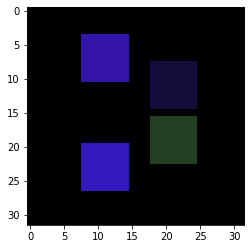

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

class EEGImagesDataset(Dataset):
    """EEGLearn Images Dataset from EEG."""
    
    def __init__(self, image, label):
        self.label = label
        self.Images = image
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.Images[idx]
        label = self.label[idx]
        sample = (image, label)
        
        return sample

eeg_images = imgs
eeg_labels = np.zeros((eeg_images.shape[0],))

eeg_images_train, eeg_images_test, eeg_labels_train, eeg_labels_test =\
    train_test_split(eeg_images, eeg_labels, shuffle=False)

eeg_images_train = EEGImagesDataset(eeg_images_train, eeg_labels_train)
eeg_images_test = EEGImagesDataset(eeg_images_test, eeg_labels_test)

train_dataloader = DataLoader(eeg_images_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(eeg_images_test, batch_size=64, shuffle=True)

# Test to make sure the reshape worked
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()

In [15]:
class LSTM(nn.Module):
    '''
    input_image: list of EEG image [batch_size, n_window, n_channel, h, w] ex. (1, 7, 3, 32, 32)
    FROM: https://github.com/VDelv/EEGLearn-Pytorch
    Build the LSTM model applying a RNN over the 7 parallel convnets outputs
    param kernel: kernel size used for the convolutional layers
    param stride: stride apply during the convolutions
    param padding: padding used during the convolutions
    param max_kernel: kernel used for the maxpooling steps
    param n_classes: number of classes
    param n_units: number of units
    return x: output of the last layers after the log softmax
    '''
    def __init__(self, n_window=7, n_channel=3, kernel=(3, 3), stride=1, padding=1,max_kernel=(2, 2), n_classes=4, n_units=128):
        super(LSTM, self).__init__()

        ## XXX: Possibly hard-coded to 32x32 images?
        self.conv1 = nn.Conv2d(n_channel,32,kernel,stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(32,32,kernel,stride=stride, padding=padding)
        self.conv3 = nn.Conv2d(32,32,kernel,stride=stride, padding=padding)
        self.conv4 = nn.Conv2d(32,32,kernel,stride=stride, padding=padding)
        self.pool1 = nn.MaxPool2d(max_kernel)
        self.conv5 = nn.Conv2d(32,64,kernel,stride=stride,padding=padding)
        self.conv6 = nn.Conv2d(64,64,kernel,stride=stride,padding=padding)
        self.conv7 = nn.Conv2d(64,128,kernel,stride=stride,padding=padding)

        # LSTM Layer
        self.rnn = nn.RNN(4*4*128, n_units, n_window)
        self.rnn_out = torch.zeros(2, 7, 128)

        self.pool = nn.MaxPool2d((n_window,1))
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(896, n_classes)
        self.max = nn.LogSoftmax()

    def forward(self, x):
        if x.get_device() == 0:
            tmp = torch.zeros(x.shape[0], x.shape[1], 128, 4, 4).cuda()
        else:
            tmp = torch.zeros(x.shape[0], x.shape[1], 128, 4, 4).cpu()
        for i in range(7):
            img = x[:, i]
            img = F.relu(self.conv1(img))
            img = F.relu(self.conv2(img))
            img = F.relu(self.conv3(img))
            img = F.relu(self.conv4(img))
            img = self.pool1(img)
            img = F.relu(self.conv5(img))
            img = F.relu(self.conv6(img))
            img = self.pool1(img)
            img = F.relu(self.conv7(img))
            tmp[:, i] = self.pool1(img)
            del img
        x = tmp.reshape(x.shape[0], x.shape[1], 4 * 128 * 4)
        del tmp
        self.rnn_out, _ = self.rnn(x)
        x = self.rnn_out.view(x.shape[0], -1)
        x = self.fc(x)
        x = self.max(x)
        return x

In [16]:
#model, trainloader, testloader, n_epoch=30, opti='SGD', learning_rate=0.0001, print_epoch =5, verbose=False
trainloader = train_dataloader
testloader = test_dataloader
n_epoch = 2
learning_rate = 0.03
print_epoch = 5
verbose = True
net = LSTM().cpu()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

for epoch in range(n_epoch):
    running_loss = 0.0
    evaluation = []
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(torch.float32).cpu())
        _, predicted = torch.max(outputs.cpu().data, 1)
        evaluation.append((predicted==labels).tolist())
        loss = criterion(outputs, labels.cpu())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    running_loss = running_loss/(i+1)
    evaluation = [item for sublist in evaluation for item in sublist]
    running_acc = sum(evaluation)/len(evaluation)
    validation_loss, validation_acc = Test_Model(net, testloader, criterion,True)

    if epoch%print_epoch==(print_epoch-1):
        print('[%d, %3d]\tloss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
         (epoch+1, n_epoch, running_loss, running_acc, validation_loss, validation_acc))
if verbose:
    print('Finished Training \n loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
             (running_loss, running_acc, validation_loss,validation_acc))

(running_loss, running_acc, validation_loss,validation_acc)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [32, 3, 3, 3], but got 3-dimensional input of size [15, 32, 4] instead

# PyTorch EEG Band Model

We will train a PyTorch model on EEG band data, in order to associate with specific actions, emotions, movements, etc.

The first step of this process will be to gather data. To do so, we will use an interactive program which prompts the wearer of the EEG headset to perform specific actions, such as open/close eyes, meditate (guided / unguided), listen to music, ingest a substance, etc. and while the wearer is doing the task, EEG waves are recorded and tagged. We can call a specific session a "survey".

In [9]:
from concurrent.futures import ThreadPoolExecutor
import json # TODO: json survey index file
import pathlib

surveys_top_dir = "../data/muse2-recordings/surveys"

def play_next_step_audio(description):
    os.system("mpg123 " + "../data/Meditation-bell-sound.mp3")
    if description is not None:
        print(os.system("bash -c 'mimic \"" + description + "\" -o EEG-Muse_tmp.wav && cvlc EEG-Muse_tmp --play-and-exit && rm EEG-Muse_tmp'"))

def record_eeg_survey(schedule, survey_tag, survey_desc, subject):
    data_files = []
    timestamp = str(datetime.datetime.now())
    survey_name = survey_tag + " " + subject + " " + timestamp
    survey_dir = surveys_top_dir + "/" + survey_name
    pathlib.Path(survey_dir).mkdir(parents=True)
    readme_file = survey_dir + "/README.md"
    audio_player_thread = ThreadPoolExecutor(max_workers=1)
    audio_file = "../data/Meditation-bell-sound.mp3"
    play_audio = lambda desc: lambda: play_next_step_audio(desc)
    
    for step, step_i in zip(schedule, range(len(schedule))):
        duration, tag, description, record = step
        full_tag = survey_tag + " " + str(step_i) + "-" + tag

        # Print desc & play bell
        print(description)
        audio_player_thread.submit(play_audio(description))
            
        # Record stream or wait
        if record:
            files = save_and_plot_muse_sample_stream(duration,
                                                     tag=full_tag, output_path=survey_dir)
            data_files.append(files)
        else:
            time.sleep(duration.total_seconds())
    
    print("Survey Completed. Thank you.")
    audio_player_thread.submit(play_audio)
    
    readme_text = "#" + survey_name + "\n\n" + survey_desc + "\n\n" +\
                  "Subject: " + subject + "\n\n" +\
                  "## Schedule\n\n" + str(schedule) + "\n\n"
    
    with open(readme_file, "w") as readme:
        readme.write(readme_text)
        
    return survey_dir

Now we will define some sessions.

Next step -- Just breathe normally, gently relax any tension


<IPython.core.display.Javascript object>


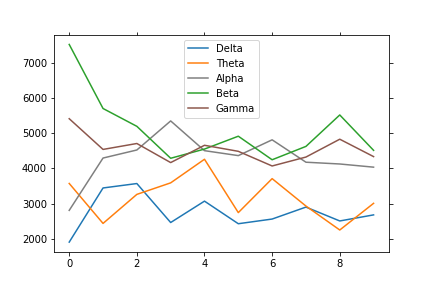

Successfully connected to muse device
Muse 2 Sample rate: 256
Muse 2 time correction: 1624477509.3179445
[[-1000.         -1000.          -503.90625     -586.42578125
      0.             1.001334  ]
 [  311.5234375   -691.40625     -508.7890625  -1000.
      0.             1.001334  ]
 [ -855.46875     -151.3671875   -507.32421875  -482.91015625
      0.             1.001334  ]
 ...
 [ -991.2109375  -1000.          -529.296875   -1000.
      0.             1.001334  ]
 [  698.2421875   -297.36328125  -537.109375    -971.6796875
      0.             1.001334  ]
 [ -995.1171875     83.0078125   -525.87890625  -109.375
      0.             1.001334  ]]
[[ -697.75390625  -691.40625     -510.25390625    68.84765625
      0.             1.996169  ]
 [-1000.         -1000.          -527.83203125  -879.8828125
      0.             1.996169  ]
 [  571.2890625   -529.296875    -513.671875    -988.76953125
      0.             1.996169  ]
 ...
 [-1000.          -918.45703125  -528.80859375  -556

'../data/muse2-recordings/surveys/Test Breathwork Jared 2021-06-23 17:17:18.125322'

In [109]:
from recorder import Muse2EEGRecorder
from survey import Survey
import datetime

test_schedule = [
    (datetime.timedelta(seconds=10), "preintro", "Just breathe normally, gently relax any tension", True)
]

short_meditation_schedule = [
    (datetime.timedelta(seconds=30), "preintro", "Just breathe normally, gently relax any tension.", False),
    (datetime.timedelta(seconds=30), "intro", "Just breathe normally, gently relax any tension.", True),
    (datetime.timedelta(minutes=2), "breath", "Notice the breath.", True),
    (datetime.timedelta(minutes=2), "body", "Notice the body.", True),
    (datetime.timedelta(minutes=30), "outro", "Open your eyes and become aware of your surroundings.", True)
]

smoke_sesh_schedule = [
    (datetime.timedelta(minutes=2), "intro", "Just breathe normally, gently relax any tension, get in a comfortable position.", True),
    (datetime.timedelta(minutes=4), "smoking", "Feel free to smoke as much as possible for four minutes, staying mindful and relaxed.", True),
    (datetime.timedelta(minutes=2), "chill", "Now, stop smoking and notice any changes in sensation.", True)
]

wim_hof_short_vid_schedule = [
    (datetime.timedelta(seconds=60), "preintro", "Just lay down, breathe normally, gently relax any tension.", False),
    (datetime.timedelta(minutes=11), "breathing", "Please start the video and follow the instructions. https://www.youtube.com/watch?v=tybOi4hjZFQ", True),
    (datetime.timedelta(seconds=60), "outro", "Notice the breath, notice any effects.", True),
]

guided_video_schedule = lambda duration: [
        (datetime.timedelta(seconds=60), "preintro", "Find a comfortable position, breathe normally, gently relax any tension.", False),
        (duration, "breathing", "Please start the video and follow the instructions.", True),
        (datetime.timedelta(minutes=2), "outro", "Notice the breath, notice any effects.", True),
    ]

%matplotlib notebook
muse2_recorder = Muse2EEGRecorder()
survey = Survey(muse2_recorder, "Half Tab Breathwork", "https://www.youtube.com/watch?v=kdaRIIIZhUc", short_meditation_schedule)
survey.record("Jared")

#record_eeg_survey(guided_video_schedule(datetime.timedelta(minutes=20)), "Breathwork",
#                  "https://www.youtube.com/watch?v=kdaRIIIZhUc", "Jared")

## Prepare Data for PyTorch

Pytorch requires a tensor of size `x`. For a given survey, the input to our neural network will be the EEG bands timeseries data, and the output will be a label telling us what it thinks the wearer is doing.

## Training

Now that we have data to work with, we will train a model to associate EEG data with the actions a user is taking.

If this proves to be too little context for the neural net, we can do a few things:

- Clean the data more effectively (de-noise, remove sections of low-quality signal)
- Provide other high-level analysis values as features (band splitting with different frame sizes, stddev, "stability of band magnitude")
- Give the model raw EEG data (probably not a good idea?)

In [ ]:
class SimpleNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x


model = LSTM()
loss_fn = torch.nn.MSELoss(size_average=False)
learning_rate = 0.03
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Clear stored gradient
    model.zero_grad()
    
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    model.hidden = model.init_hidden()
    
    # Forward pass
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

loss_fn = torch.nn.MSELoss(size_average=False)
 
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
 
#####################
# Train model
#####################
 
hist = np.zeros(num_epochs)
 
for t in range(num_epochs):
    # Clear stored gradient
    model.zero_grad()
    
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_pred = model(X_train)
 
    loss = loss_fn(y_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
 
    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()
 
    # Backward pass
    loss.backward()
 
    # Update parameters
    optimiser.step()

In [1]:
import numpy as np
import mne

from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

muse2_sensors = ["eeg1", "eeg2", "eeg3", "eeg4"]
muse_session_lsd_postpeak = pd.read_csv("../data/muse2-recordings/surveys/Breathwork Jared 2021-06-22 16:03:24.013152/eeg_raw_Breathwork 1-breathing-2021-06-22 16:04:24.176301.csv")
muse_session_lsd_postpeak = preprocess_eeg(muse_session_lsd_postpeak)[muse2_sensors].to_numpy()

# Create the info structure needed by MNE
info = mne.create_info(muse2_sensors, DEFAULT_SAMPLE_RATE)

# Finally, create the Raw object
raw = mne.io.RawArray(muse_session_lsd_postpeak.T, info)

# Do PSD
alpha_fmin, alpha_fmax = eeg_bands["Alpha"]
psds, freq = mne.time_frequency.psd_welch(raw, fmin=alpha_fmin, fmax=alpha_fmax, picks=muse2_sensors, average='mean')

print(psds.shape, freq.shape)

# Initialize a FOOOFGroup object, with desired settings
fg = FOOOFGroup(peak_width_limits=[1, 6], min_peak_height=0.15,
                peak_threshold=2., max_n_peaks=6, verbose=False)

# Define the frequency range to fit
freq_range = [1, 30]

# Fit the power spectrum model across all channels
fg.fit(freq, psds, freq_range)

# Check the overall results of the group fits
fg.plot()

"""
# Plot it!
%matplotlib notebook
for i in range(4):
    plt.plot(freq, psds[i, :], label=muse2_sensors[i])
plt.title("Alpha frequencies by sensor")
plt.legend()
#raw.plot()
"""

NameError: name 'pd' is not defined

Installing fooof...
Adding fooof to Pipfile's [packages]...
✔ Installation Succeeded 
Pipfile.lock not found, creating...
Locking [dev-packages] dependencies...
Locking [packages] dependencies...
Building requirements...
Resolving dependencies...
✘ Locking Failed! 
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/pipenv/resolver.py", line 764, in <module>
    main()
  File "/usr/lib/python3.9/site-packages/pipenv/resolver.py", line 758, in main
    _main(parsed.pre, parsed.clear, parsed.verbose, parsed.system, parsed.write,
  File "/usr/lib/python3.9/site-packages/pipenv/resolver.py", line 741, in _main
    resolve_packages(pre, clear, verbose, system, write, requirements_dir, packages, dev)
  File "/usr/lib/python3.9/site-packages/pipenv/resolver.py", line 702, in resolve_packages
    results, resolver = resolve(
  File "/usr/lib/python3.9/site-packages/pipenv/resolver.py", line 684, in resolve
    return resolve_deps(
  File "/usr/lib/python3.9/site-package